## ECHR Dataset - Component Classification results

This notebook contains functions to measure the performance of a classifier applied over a set of annotations.

The output of the classification files is expected to be compatible with the output of the UKPLab models. Each line contains the token, the true label, and predicted label of one classification example, in that order, separated by tabs. The first row has the columns names. For example:

`word_n    I-Premise:2:Support    I-Premise:-1:Support`

Training results must be stored in tsv format with the following columns: epoch, modelName, dev_score, test_score, max_dev_score, max_test_score

In [1]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
import pandas
import pickle
import os
import re
import seaborn as sns
from sklearn import metrics

import colors
import learning_metrics
import performance_metrics
import visualizations

In [2]:
import importlib
importlib.reload(colors)
importlib.reload(learning_metrics)
importlib.reload(performance_metrics)
importlib.reload(visualizations)

<module 'visualizations' from '/home/mteruel/am/argument_mining/evaluation/visualizations.py'>

In [3]:
CC_EXPERIMENTS_DIRS = [
#     '../../results/echr/claim_detection/paragraph/19-10-10-19-02',
#     '../../results/echr/claim_detection/paragraph/19-10-10-20-35',
#     '../../results/echr/claim_detection/paragraph/19-10-10-21-28',
#     '../../results/echr/claim_detection/paragraph/19-10-10-22-16',
#     '../../results/echr/claim_detection/paragraph/19-10-10-23-22',
#     '../../results/echr/claim_detection/paragraph/19-10-11-00-46',
#     '../../results/echr/claim_detection/paragraph/19-10-11-01-54',
#     '../../results/echr/claim_detection/paragraph/19-10-11-03-29',
#     '../../results/echr/claim_detection/paragraph/19-10-11-05-13',
#     '../../results/echr/claim_detection/paragraph/19-10-11-06-21',
#     '../../results/echr/claim_detection/paragraph/19-10-11-07-22',
#     '../../results/echr/claim_detection/paragraph/19-10-11-08-52',
#     '../../results/echr/claim_detection/paragraph/19-10-11-10-14',
#     '../../results/echr/claim_detection/paragraph/19-10-11-11-29',
#     '../../results/echr/claim_detection/paragraph/19-10-11-12-49',
#     '../../results/echr/claim_detection/paragraph/19-10-11-14-16',
#     '../../results/echr/claim_detection/paragraph/19-10-11-15-13',
#     '../../results/echr/claim_detection/paragraph/19-10-11-16-11',
#     '../../results/echr/claim_detection/paragraph/19-10-11-17-14',
    # '../../results/echr/claim_detection/paragraph/19-10-14-21-21',
    # '../../results/echr/claim_detection/paragraph/19-10-14-22-23',
    # '../../results/echr/claim_detection/paragraph/19-10-14-23-23',
    # '../../results/echr/claim_detection/paragraph/19-10-15-00-37',
    # '../../results/echr/claim_detection/paragraph/19-10-15-02-10',
    # '../../results/echr/claim_detection/paragraph/19-10-15-03-00',
    # '../../results/echr/claim_detection/paragraph/19-10-15-04-13',
    # '../../results/echr/claim_detection/paragraph/19-10-15-05-29',
    # '../../results/echr/claim_detection/paragraph/19-10-15-06-36',
    # '../../results/echr/claim_detection/paragraph/19-10-15-07-26',
    # '../../results/echr/claim_detection/paragraph/19-10-15-08-36',
    # '../../results/echr/claim_detection/paragraph/19-10-15-10-27',
    # '../../results/echr/claim_detection/paragraph/19-10-15-12-23',
    # '../../results/echr/claim_detection/paragraph/19-10-15-14-08',
    # '../../results/echr/claim_detection/paragraph/19-10-15-15-52',
    # '../../results/echr/claim_detection/paragraph/19-10-15-17-53',
    # '../../results/echr/claim_detection/paragraph/19-10-15-19-46',
    # '../../results/echr/claim_detection/paragraph/19-10-15-22-02',
    # '../../results/echr/claim_detection/paragraph/19-10-16-00-01',
    # '../../results/echr/claim_detection/paragraph/19-10-16-01-42',
    # '../../results/echr/claim_detection/paragraph/19-10-16-04-01',
    # '../../results/echr/claim_detection/paragraph/19-10-16-05-52',
    # '../../results/echr/claim_detection/paragraph/19-10-16-07-48',
    # '../../results/echr/claim_detection/paragraph/19-10-16-09-41',
    # '../../results/echr/claim_detection/paragraph/19-10-16-11-26',
    # Self attention
    # '../../results/echr/claim_detection/paragraph/19-10-24-13-49',
    # '../../results/echr/claim_detection/paragraph/19-10-24-14-47',
    # '../../results/echr/claim_detection/paragraph/19-10-24-15-36',
    '../../results/echr/claim_detection/paragraph/19-10-30-11-19',
    '../../results/echr/claim_detection/paragraph/19-10-30-12-29',
    '../../results/echr/claim_detection/paragraph/19-10-30-13-15',
    '../../results/echr/claim_detection/paragraph/19-10-30-14-14',
    '../../results/echr/claim_detection/paragraph/19-10-30-15-00',
    '../../results/echr/claim_detection/paragraph/19-10-30-16-09',
    '../../results/echr/claim_detection/paragraph/19-10-30-17-05',
    '../../results/echr/claim_detection/paragraph/19-10-30-17-49',
    '../../results/echr/claim_detection/paragraph/19-10-30-18-40',
    '../../results/echr/claim_detection/paragraph/19-10-30-19-45',
    '../../results/echr/claim_detection/paragraph/19-10-30-20-42',
    '../../results/echr/claim_detection/paragraph/19-10-30-22-01',
    '../../results/echr/claim_detection/paragraph/19-10-30-23-04',
    '../../results/echr/claim_detection/paragraph/19-10-30-23-57',
    '../../results/echr/claim_detection/paragraph/19-10-31-00-50',
    '../../results/echr/claim_detection/paragraph/19-10-31-01-37',
    '../../results/echr/claim_detection/paragraph/19-10-31-02-20',
    '../../results/echr/claim_detection/paragraph/19-10-31-03-15',
    '../../results/echr/claim_detection/paragraph/19-10-31-03-54',
    '../../results/echr/claim_detection/paragraph/19-10-31-04-37',
    
]

## Classification Results

In [4]:
echr_extra_keys = {
    'Partition': lambda prediction_file: re.search('.*partition(\d+).*', prediction_file).group(1)
}

In [5]:
cc_results = performance_metrics.architecture_metrics(CC_EXPERIMENTS_DIRS, keys=echr_extra_keys)
cc_results

DEBUG: classes used ['O' 'I-claim']
DEBUG: classes used ['O' 'I-claim']
DEBUG: classes used ['O' 'I-claim']
DEBUG: classes used ['O' 'I-claim']
DEBUG: classes used ['O' 'I-claim']
DEBUG: classes used ['O' 'I-claim']
DEBUG: classes used ['O' 'I-claim']
DEBUG: classes used ['O' 'I-claim']
DEBUG: classes used ['O' 'I-claim']
DEBUG: classes used ['O' 'I-claim']
DEBUG: classes used ['O' 'I-claim']
DEBUG: classes used ['O' 'I-claim']
DEBUG: classes used ['O' 'I-claim']
DEBUG: classes used ['O' 'I-claim']
DEBUG: classes used ['O' 'I-claim']
DEBUG: classes used ['O' 'I-claim']
DEBUG: classes used ['O' 'I-claim']
DEBUG: classes used ['O' 'I-claim']
DEBUG: classes used ['O' 'I-claim']
DEBUG: classes used ['O' 'I-claim']
DEBUG: classes used ['O' 'I-claim']
DEBUG: classes used ['O' 'I-claim']
DEBUG: classes used ['O' 'I-claim']
DEBUG: classes used ['O' 'I-claim']
DEBUG: classes used ['O' 'I-claim']
DEBUG: classes used ['O' 'I-claim']
DEBUG: classes used ['O' 'I-claim']
DEBUG: classes used ['O' 'I-

,Classifier,Dataset,Accuracy,Precision,Recall,F1-Score,Support,Partition
0,19-10-30-11-19,dev,0.722399,0.655228,0.648862,0.651698,3134,4
1,19-10-30-11-19,dev,0.687281,0.635041,0.618892,0.623383,2571,0
2,19-10-30-11-19,test,0.733947,0.652186,0.723817,0.660225,4781,2
3,19-10-30-11-19,dev,0.653478,0.566111,0.563107,0.564278,3134,6
4,19-10-30-11-19,dev,0.728066,0.684215,0.610700,0.615910,2291,2
5,19-10-30-11-19,test,0.616014,0.556898,0.626735,0.515280,2810,0
6,19-10-30-11-19,test,0.623493,0.534609,0.526278,0.521060,2571,4
7,19-10-30-11-19,test,0.761240,0.746339,0.651527,0.664988,2291,6
0,19-10-30-12-29,dev,0.769096,0.750321,0.669738,0.685338,2291,2
1,19-10-30-12-29,dev,0.640715,0.576746,0.583686,0.578507,3134,6


In [6]:
# Only ECHR

cc_results_dev = cc_results.groupby(['Classifier', 'Dataset']).agg('mean').reset_index()
cc_results_dev[cc_results_dev.Dataset == 'dev']

,Classifier,Dataset,Accuracy,Precision,Recall,F1-Score
0,19-10-30-11-19,dev,0.697806,0.635149,0.610390,0.613817
2,19-10-30-12-29,dev,0.699006,0.645845,0.620293,0.625001
4,19-10-30-13-15,dev,0.709342,0.681889,0.574520,0.560344
6,19-10-30-14-14,dev,0.673695,0.591073,0.544002,0.534704
8,19-10-30-15-00,dev,0.711852,0.667219,0.646456,0.646621
10,19-10-30-16-09,dev,0.696072,0.627111,0.617802,0.613765
12,19-10-30-17-05,dev,0.686801,0.607830,0.576395,0.578950
14,19-10-30-17-49,dev,0.691238,0.602086,0.569787,0.567801
16,19-10-30-18-40,dev,0.705977,0.650938,0.607528,0.609798
18,19-10-30-19-45,dev,0.680700,0.613685,0.554138,0.533622


### Comparison between classifiers

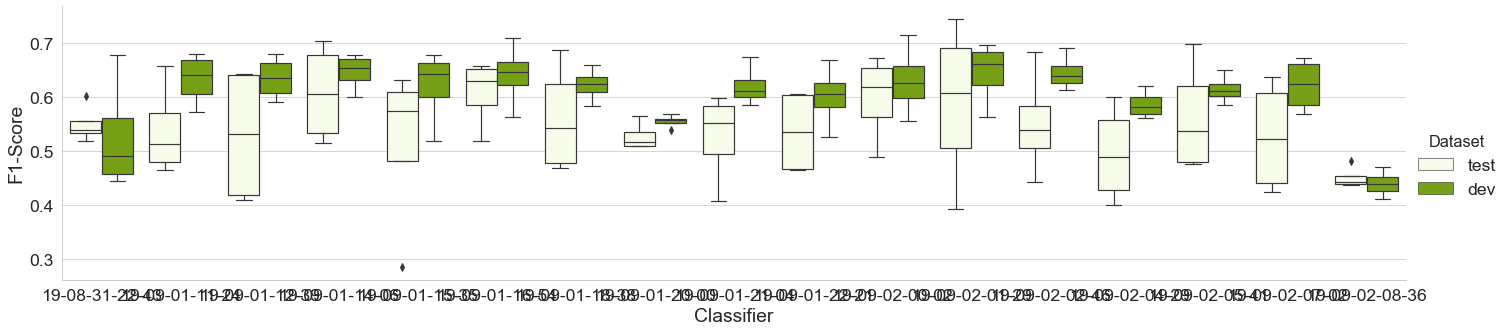

In [40]:
sns.catplot(data=cc_results,
            x='Classifier', kind='box', y='F1-Score', hue='Dataset',
            aspect=4, height=5, color=colors.green)

In [41]:
cc_results_stacked_metrics = cc_results.drop(columns='Support').set_index(
    ['Classifier', 'Dataset', 'Partition']).stack().reset_index().rename(
    columns={0: 'Metric Value', 'level_3': 'Metric'})

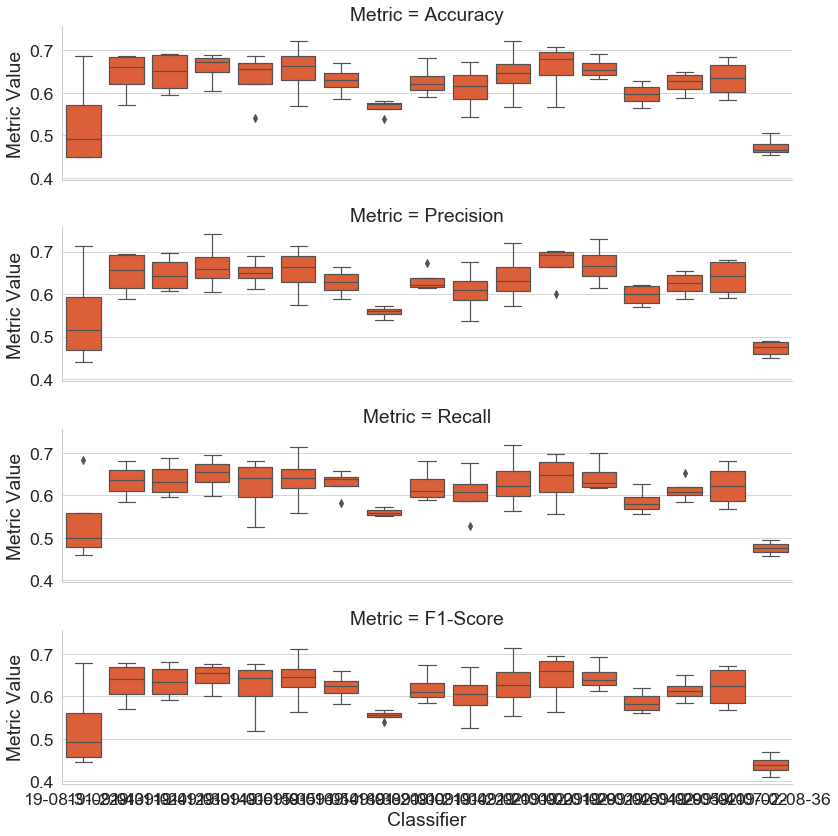

In [42]:
sns.catplot(data=cc_results_stacked_metrics[cc_results_stacked_metrics.Dataset == 'dev'],
            x='Classifier', kind='box', y='Metric Value', row='Metric',
            aspect=4, height=3, color=colors.red)

## Learning rate

In [12]:
cc_learning = learning_metrics.architecture_learning(CC_EXPERIMENTS_DIRS, keys=echr_extra_keys)
cc_learning[:4]

,epoch,Dataset,Metric Value,Classifier,Partition
0,1,dev,0.541158,19-10-10-19-02,0
1,1,test,0.799640,19-10-10-19-02,0
2,2,dev,0.561205,19-10-10-19-02,0
3,2,test,0.807196,19-10-10-19-02,0


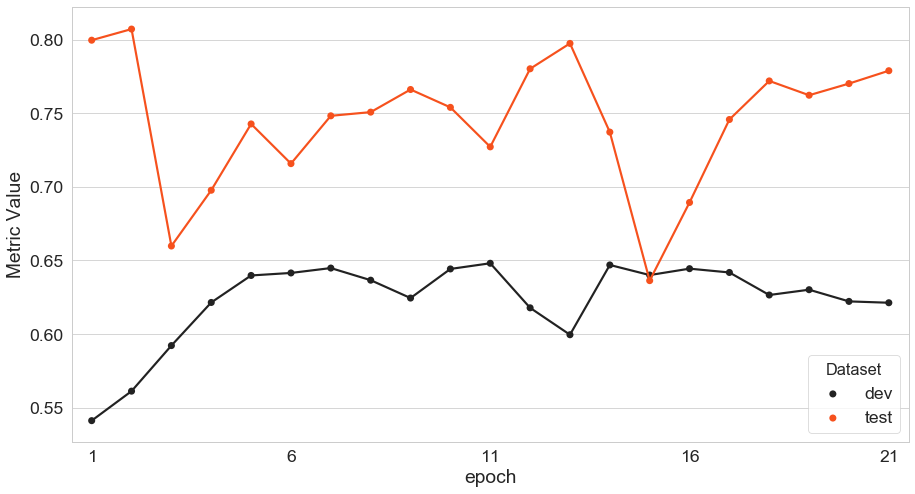

In [14]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.pointplot(data=cc_learning[(cc_learning.Classifier == '19-10-10-19-02') & (cc_learning.Partition == '0')],
              x='epoch', y='Metric Value', hue='Dataset',
              aspect=6, join=True,
              color=colors.red, ax=ax)
# Set xticks every 5 elements
labels = ax.get_xticklabels() # get x labels
for i,l in enumerate(labels):
    if(i%5 != 0): labels[i] = '' # skip even labels
ax.set_xticklabels(labels); # set new labels

### Confusion matrix

In [16]:
print(CC_EXPERIMENTS_DIRS[8])

../../results/echr/claim_detection/paragraph/19-10-11-05-13


              precision    recall  f1-score   support

     I-claim       0.52      0.53      0.52       838
           O       0.77      0.77      0.77      1733

   micro avg       0.69      0.69      0.69      2571
   macro avg       0.65      0.65      0.65      2571
weighted avg       0.69      0.69      0.69      2571



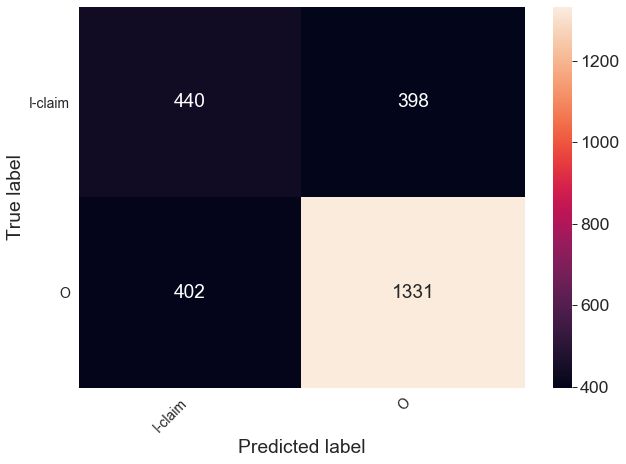

In [17]:
performance_metrics.plot_confusion_matrix(CC_EXPERIMENTS_DIRS[8], partition=0)

---

# Classifier variance

In [13]:
hyperparameters = pandas.read_csv('../../results/echr/echr_claim_detection_results.tsv2', sep='\t')
hyperparameters = hyperparameters.rename(columns={'Name': 'Classifier'})
hyperparameters['Attention type'] = hyperparameters['Attention type'].replace('None', 'No attention')
hyperparameters['Activation'] = hyperparameters['Activation'].replace('None', 'na')
hyperparameters[:3]

,Classifier,Accuracy,Precision,Recall,F1-Score,Attention type,Activation,Heads,Attention size,Config,...,Separation,Char embed,Word emb,Char embed size,Last layer,LSTM layer size,Dropout,Batch Size,Epochs,Patience
0,19-10-10-19-02,0.723873,0.664917,0.642637,0.649662,No attention,na,NaN,NaN,Exploration,...,Paragraph,None,konminos,64,CRF,50,0.3,100,NaN,NaN
1,19-10-10-20-35,0.701807,0.649489,0.655267,0.646641,No attention,na,NaN,NaN,Exploration,...,Paragraph,None,konminos,64,CRF,100,0.4,200,NaN,NaN
2,19-10-10-21-28,0.707004,0.650080,0.631514,0.632327,No attention,na,NaN,NaN,Exploration,...,Paragraph,lstm,konminos,16,Softmax,50,0.2,200,NaN,NaN


In [14]:
hyperparameters['Activation'].unique()

array(['na', 'linear', 'tanh', 'sigmoid'], dtype=object)

## Comparing attention mechanisms

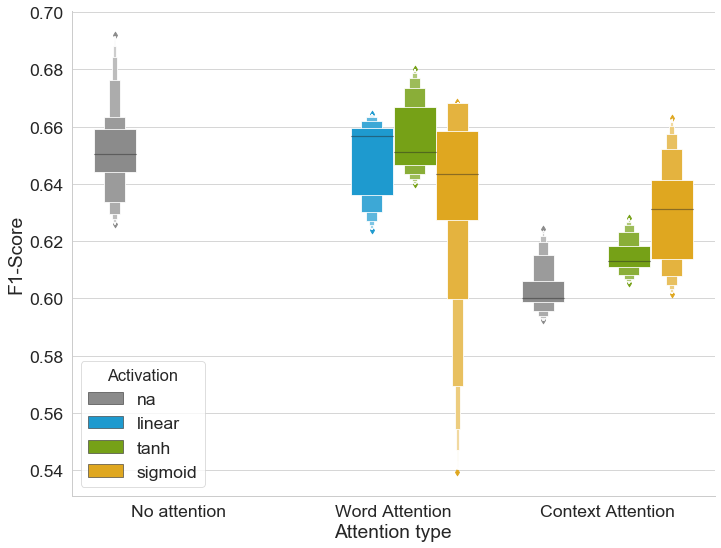

In [15]:
sns.catplot(data=hyperparameters, kind='boxen',
            y='F1-Score', x='Attention type', hue='Activation',
            height=8, aspect=1.3, legend_out=False, palette=visualizations.activation_palette)

In [7]:
hyperparameters['Attention type'].unique()

array(['No attention', 'Word Attention'], dtype=object)

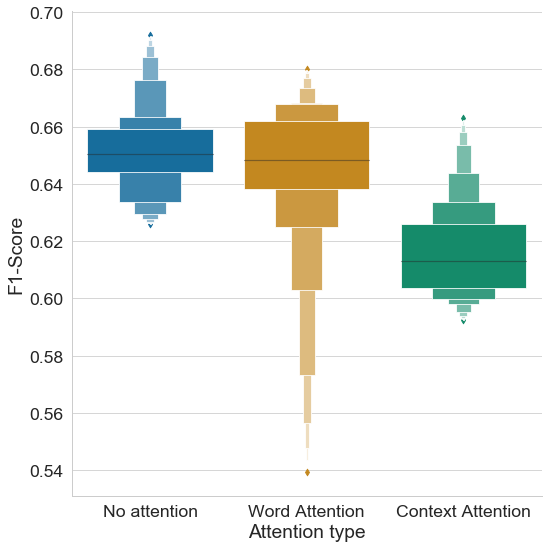

In [16]:
sns.catplot(data=hyperparameters, kind='boxen',
            y='F1-Score', x='Attention type',
            height=8, legend_out=False)#, palette=visualizations.att_palette)

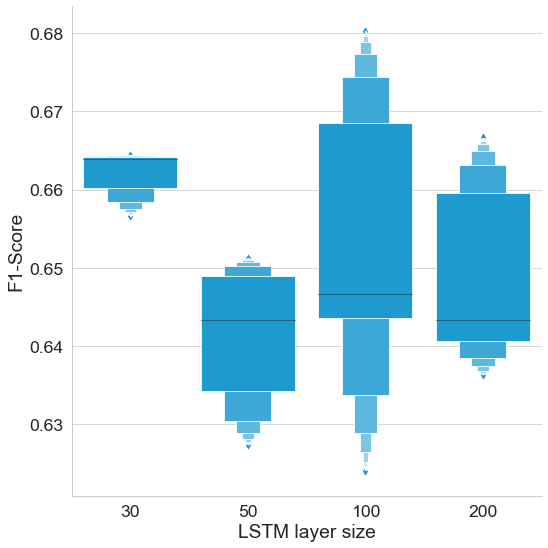

In [37]:
sns.catplot(data=hyperparameters[hyperparameters.Config == 'Exploration'], kind='boxen',
            y='F1-Score', x='LSTM layer size',# hue='Time/Feature',
            height=8, legend_out=False, color=colors.blue)

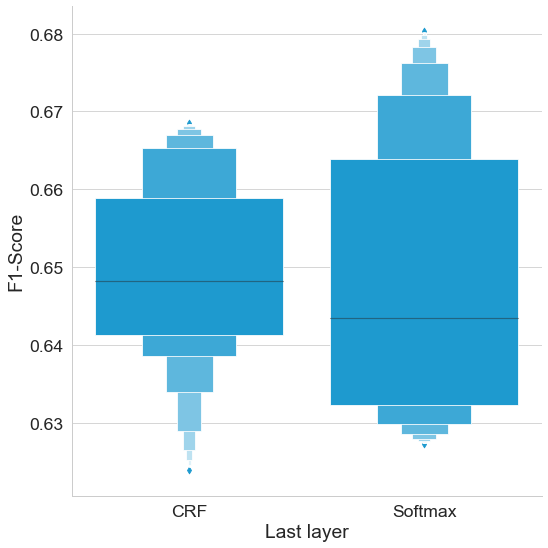

In [38]:
sns.catplot(data=hyperparameters[hyperparameters.Config == 'Exploration'], kind='boxen',
            y='F1-Score', x='Last layer',
            height=8, legend_out=False, color=colors.blue)

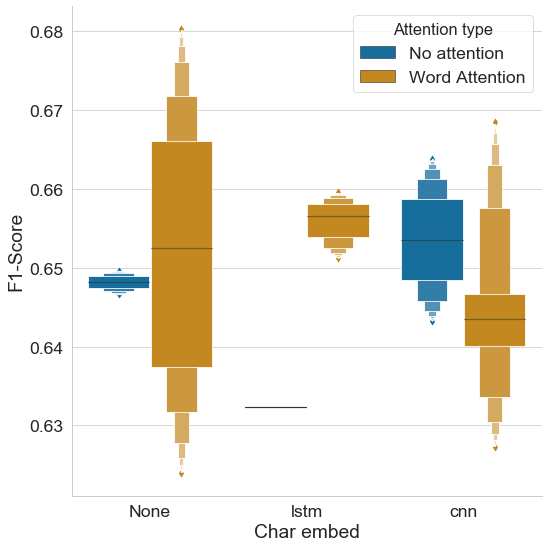

In [39]:
sns.catplot(data=hyperparameters[hyperparameters.Config == 'Exploration'], kind='boxen',
            y='F1-Score', x='Char embed', hue='Attention type',
            height=8, legend_out=False)

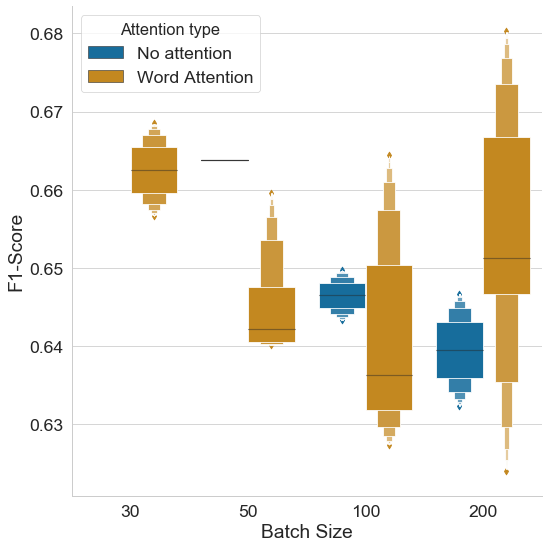

In [40]:
sns.catplot(data=hyperparameters[hyperparameters.Config == 'Exploration'], kind='boxen',
            y='F1-Score', x='Batch Size', hue='Attention type',
            height=8, legend_out=False)